In [11]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle
import keras.utils as image

In [12]:
images = glob.glob('BSDS200/*.png')

In [13]:
print(len(images))

200


In [14]:
images=images[0:1000]

In [15]:
#image=images[0]
img = image.load_img('img_align_celeba/img_align_celeba\\000001.jpg', target_size=(80,80,3))
img = image.img_to_array(img)
img = img/255.

In [16]:
img

array([[[0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        ...,
        [0.80784315, 0.72156864, 0.4862745 ],
        [1.        , 0.92941177, 0.85490197],
        [0.99607843, 0.93333334, 0.87058824]],

       [[0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        ...,
        [0.94509804, 0.8666667 , 0.6666667 ],
        [0.96862745, 0.9019608 , 0.83137256],
        [0.99607843, 0.93333334, 0.87058824]],

       [[0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        ...,
        [1.        , 0.9411765 , 0.78431374],
        [0.9529412 , 0.8901961 , 0.827451  ],
        [0.9843137 , 0.92156863, 0.85882354]],

       ...,

       [[0.6039216 , 0.35686275, 0.15686275],
        [0.8666667 , 0.6039216 , 0.42745098],
        [0.57254905, 0

In [17]:
from tqdm import tqdm
progress = tqdm(total= len(images), position=0)
def read(paths):
    res=[]
    for path in paths:
      img = image.load_img(path, target_size=(80,80,3))
      img = image.img_to_array(img)
      img = img/255.
      progress.update(1)
      res.append(img)
    return res

img_array=read(images)

0it [00:23, ?it/s]                                                                             | 0/200 [00:00<?, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.92it/s]

In [18]:
len(img_array)

200

In [19]:
all_images = np.array(img_array)
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [20]:
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA)
  return low_res_image

In [21]:
train_x_px = []
for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)
train_x_px = np.array(train_x_px)   #Distorted images
# get low resolution images for the validation set
val_x_px = []
for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)
val_x_px = np.array(val_x_px)     #Distorted images


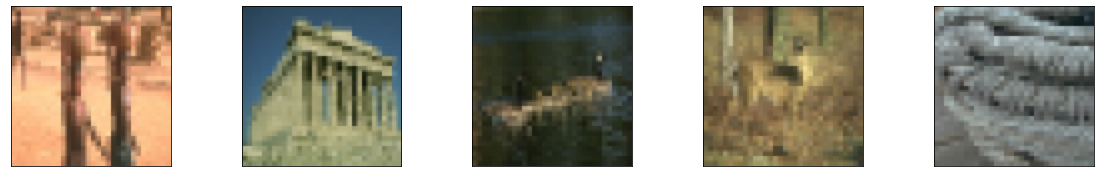

In [22]:
n=5
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [23]:
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])
# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 80, 80, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 40, 40, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [24]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

In [25]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=100,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00, 23.92it/s]

5/5 [==============================] - 62s 11s/step - loss: 0.1245 - accuracy: 0.2764 - val_loss: 0.0309 - val_accuracy: 0.3549
Epoch 2/100
5/5 [==============================] - 35s 7s/step - loss: 0.0376 - accuracy: 0.3987 - val_loss: 0.0338 - val_accuracy: 0.4360
Epoch 3/100
5/5 [==============================] - 33s 7s/step - loss: 0.0245 - accuracy: 0.5153 - val_loss: 0.0235 - val_accuracy: 0.5823
Epoch 4/100
5/5 [==============================] - 32s 7s/step - loss: 0.0184 - accuracy: 0.5533 - val_loss: 0.0177 - val_accuracy: 0.4499
Epoch 5/100
5/5 [==============================] - 32s 7s/step - loss: 0.0157 - accuracy: 0.5059 - val_loss: 0.0146 - val_accuracy: 0.7119
Epoch 6/100
5/5 [==============================] - 37s 8s/step - loss: 0.0136 - accuracy: 0.6895 - val_loss: 0.0125 - val_accuracy: 0.7276
Epoch 7/100
5/5 [==============================] - 32s 7s/step - loss: 0.0122 - accuracy: 0.7096 - val_loss: 0.0110 - val_accuracy: 0.7746
Epoch 8/100
5/5 [=====================

In [26]:
results = autoencoder.evaluate(val_x_px, val_x)
print('val_loss, val_accuracy', results)

2/2 [==============================] - 2s 359ms/step - loss: 0.0069 - accuracy: 0.8947
val_loss, val_accuracy [0.006941939704120159, 0.8946835994720459]


2/2 [==============================] - 3s 367ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


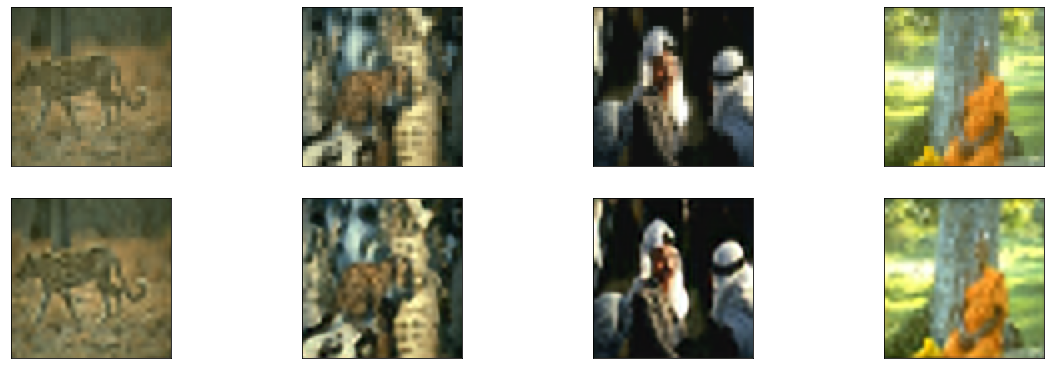

In [27]:
predictions = autoencoder.predict(val_x_px)
n = 4
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [71]:
fake_image=predictions[20]
hr_image=val_x_px[20]
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR Achieved: 82.342438


In [72]:
def MSE(img1, img2):
        squared_diff = (img1 -img2) ** 2
        summed = np.sum(squared_diff)
        num_pix = img1.shape[0] * img1.shape[1] #img1 and 2 should have same shape
        err = summed / num_pix
        return err
error=MSE(fake_image,hr_image)
error

0.0011375164985656739